In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('/Users/theot/Documents/SEGR_0D/EGR0D/'))
if module_path not in sys.path:
    sys.path.append(module_path)

#sys.path.remove('/Users/theot/Documents/SEGR_0D/EGR0D/')
print(sys.path)

['/Users/theot/Documents/SEGR_0D/EGR0D/src', '/Users/theot/Documents/SEGR_0D/EGR0D/src', '/Users/theot/Documents/arcane/ARCANE', '/opt/homebrew/anaconda3/envs/can260/lib/python39.zip', '/opt/homebrew/anaconda3/envs/can260/lib/python3.9', '/opt/homebrew/anaconda3/envs/can260/lib/python3.9/lib-dynload', '', '/opt/homebrew/anaconda3/envs/can260/lib/python3.9/site-packages', '/Users/theot/Documents/SEGR_0D/EGR0D']


In [20]:
from egr import *
import time
from egr_multiproc import *
import pandas as pd

In [32]:
if __name__ == '__main__':
    # get the start time
    st = time.time()

    config = case('CH4:1.',                     #fuel compo
                  'O2:1. N2:3.76',              #ox compo
                  'CO2:0.5',                    #egr compo
                  3960.0,                       #thermal output power (kind of useless)
                  0.0001,                       #egr rate
                  'vol'                         #egr rate unit
                  )
    dfs=[]
    pressures = [500000] #initial pressures to test in Pa
    for p in pressures:
        #set reservoirs thermo-state
        config.res.fuel = create_reservoir(config.compo.fuel,'gri30.cti', 300.0, p)
        config.res.ox = create_reservoir(config.compo.ox,'air.xml', 300.0, p)
        config.res.egr = create_reservoir(config.compo.egr,'gri30.cti', 300.0, p)

        #range of computation
        egr_percentages = [0.0,0.1,0.3] #np.arange(0.0,0.51,0.1)
        df = pd.DataFrame()
        if(True):
            for egr_rate in egr_percentages:
                config.egr_rate = egr_rate #override config.egr_rate set during object instanciation
                phi_range = np.arange(1.0,1.25,0.8)
                reactor,results,pdresult = compute_solutions_1D(config,phi_range,real_egr=False,phi_air=False)
                #plt.plot(phi_range,results[:,4],label='EGR reacteurs:'+str(round(config.egr_rate*100,1)),marker='o')
                #subplot_data(phi_range,results,'Phi',['T[K]','HRR[W/m3]','Y_O2','Y_CO2'],'EGR rate (%):'+str(round(config.egr_rate*100,1))+'%')
                df=pd.concat([df,pdresult])
        
        #df = df.pivot_table(index='phi',columns='EGR',values='u')
        #print_reactor(df)
        # get the end time
        et = time.time()

        # get the execution time
        elapsed_time = et - st
        print('Execution time:', elapsed_time, 'seconds')
        dfs.append(df)

/opt/homebrew/anaconda3/envs/can260/lib/python3.9/site-packages/cantera/onedim.py:778: FutureWarning: An appropriate transport model
should be set when instantiating the Solution ('gas') object.
Implicit setting of the transport model may be deprecated in the future.
  self.flame = IdealGasFlow(gas, name='flame')


2.7633486692015206
flame CH4 X 0.0950570342205323
Solution saved to file flame.xml as solution gri30.cti.


/opt/homebrew/anaconda3/envs/can260/lib/python3.9/site-packages/cantera/onedim.py:778: FutureWarning: An appropriate transport model
should be set when instantiating the Solution ('gas') object.
Implicit setting of the transport model may be deprecated in the future.
  self.flame = IdealGasFlow(gas, name='flame')


3.2523375580904093
flame CH4 X 0.08555133079848812
Solution saved to file flame.xml as solution gri30.cti.


/opt/homebrew/anaconda3/envs/can260/lib/python3.9/site-packages/cantera/onedim.py:778: FutureWarning: An appropriate transport model
should be set when instantiating the Solution ('gas') object.
Implicit setting of the transport model may be deprecated in the future.
  self.flame = IdealGasFlow(gas, name='flame')


4.6494486692015204
flame CH4 X 0.06653992395417888
Solution saved to file flame.xml as solution gri30.cti.
Execution time: 5156.62117099762 seconds


In [30]:
dfsi=dfs
filenames = ['verif_Tin300_vol'+str(idx)+'.pkl' for idx in range(len(dfsi))]
[df.to_pickle(filenames[idx]) for idx,df in enumerate(dfsi)]
params={'pressure':pressures,
        'filename':filenames,
        'scheme':'Aramco13.cti'}

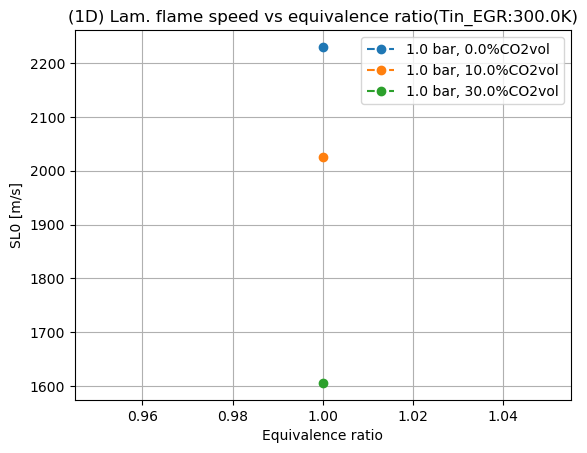

In [31]:
#filenames = ['df_new_mdots'+str(idx)+'.pkl' for idx in range(2)]
#pressures = [100000,500000] #initial pressures to test in Pa
#egr_percentages = [0.0,0.1,0.3] #np.arange(0.0,0.51,0.1)

dfsr = []
[dfsr.append(pd.read_pickle(file)) for file in filenames]
dfs_unique_var=[df.pivot_table(index='phi',columns='EGR',values='T') for df in dfsr]

fig, ax = plt.subplots(1,1)

dfsc=pd.concat(dfs_unique_var, axis = 1)

human_labels = [(str(round(p/100000,1))+' bar, '+str(round(e*100,1))+"%CO2"+config.egr_unit) for p in pressures for e in egr_percentages]
T=config.res.egr.thermo.T
dfsc.plot(ax=ax, style='--o',title='(1D) Lam. flame speed vs equivalence ratio'+'(Tin_EGR:'+str(round(T,0))+'K)',
            #Pin:'+str(round(P/100000,0))+'bar)',
            xlabel='Equivalence ratio',ylabel='SL0 [m/s]')

#equilibrate_data=main()
#equilibrate_data=equilibrate_data.pivot_table(columns='EGR',index='phi',values='T')
#equilibrate_data.plot(ax=ax, style='--x',title='Temperature vs equivalence ratio',xlabel='Equivalence ratio',ylabel='T',legend=False, label='EGR Reactor')
#plt.xticks(np.arange(0.8,1.21,0.05))
#plt.yticks(range(1500,2305,100))
plt.grid()
plt.legend(loc='best')
ax.legend(human_labels)
plt.show()